# Video pipeline with Yolo + Resnet Model

In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative

In [2]:
metaserieses = [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
serieses = [1, 2, 3, 21, 22, 23, 41, 42, 43, 61, 62, 63]

series_names = None
# series_names = {
#     # 1: "IPA-accuracy",
#     2: "IPA",
#     # 3: "IPA-cost",
#     4: "FA2-high",
#     # 5: "FA2-high",
#     # 6: "RIM-low",
#     7: "RIM-high",
# }

series_paths = {
series: os.path.join(FINAL_RESULTS_PATH, "metaseries", str(metaseries), "series", str(series))
    for series, metaseries in zip(serieses, metaserieses)
}

loaders = {
series: AdaptationParser(
        series_path=series_path, model_name="nlp", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [3]:
series_paths

{1: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/16/series/1',
 2: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/16/series/2',
 3: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/16/series/3',
 21: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/16/series/21',
 22: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/16/series/22',
 23: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/16/series/23',
 41: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/16/series/41',
 42: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/16/series/42',
 43: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/16/series/43',
 61: '/home/cc/infernece-pipeline-joint-optimization/data/results/final/metaseries/16/series/61',
 62: '/home/cc/infernece-p

In [4]:
loaders

{1: <experiments.utils.parser.AdaptationParser at 0x7ffb45710be0>,
 2: <experiments.utils.parser.AdaptationParser at 0x7ffb45710bb0>,
 3: <experiments.utils.parser.AdaptationParser at 0x7ffbec2da400>,
 21: <experiments.utils.parser.AdaptationParser at 0x7ffb4f04bd90>,
 22: <experiments.utils.parser.AdaptationParser at 0x7ffb457108b0>,
 23: <experiments.utils.parser.AdaptationParser at 0x7ffbec34fb20>,
 41: <experiments.utils.parser.AdaptationParser at 0x7ffb45765700>,
 42: <experiments.utils.parser.AdaptationParser at 0x7ffbec360d90>,
 43: <experiments.utils.parser.AdaptationParser at 0x7ffb4545e1c0>,
 61: <experiments.utils.parser.AdaptationParser at 0x7ffb4547af10>,
 62: <experiments.utils.parser.AdaptationParser at 0x7ffb4540e970>,
 63: <experiments.utils.parser.AdaptationParser at 0x7ffb4540ed60>}

In [5]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 1 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 2,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 8,
    'benchmark_duration': 1,
    'beta': 0.125,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10,
    'gamma': 1e-06,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'logs_enabled': False,
    'metadata': 'bursty - ipa - cpu type: compute_cascadelake_r_ib',
    'metaseries': 18,
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
              

In [6]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [7]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{1: True,
 2: True,
 3: True,
 21: True,
 22: True,
 23: True,
 41: True,
 42: True,
 43: True,
 61: True,
 62: True,
 63: True}

In [8]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [9]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Replica Changes
1. Total
2. Per node

In [10]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]
    # draw_temporal(replica_changes[series], adaptation_intervals[series])
replica_changes_total = {key: {'total': value['total']} for key, value in replica_changes.items()}
ylabel = "replicas"
# draw_temporal(
#     replica_changes_total, adaptation_intervals, ylabel=ylabel, multiple_experiments=True
# )
# draw_cumulative(replica_changes_total, multiple_experiments=True, ylabel=ylabel)

## Per Container Core changes
1. Total
2. Per Node

In [11]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]
    # draw_temporal(core_changes[series])
ylabel = "core changes"
# draw_temporal(
#     core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
# )
core_changes_total = {key: {'total': value['total']} for key, value in core_changes.items()}
# draw_cumulative(
#     core_changes_total, multiple_experiments=True, ylabel=ylabel, series_names=series_names
# )

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

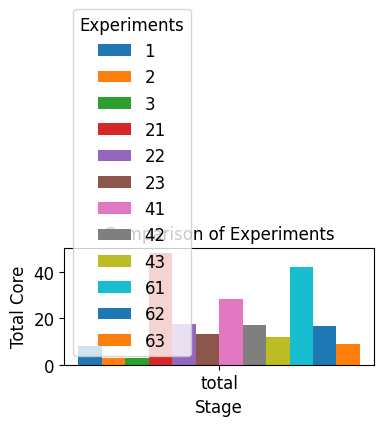

In [12]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]["total"] = total.tolist()
    # draw_temporal(total_core_changes[series])
ylabel = "Total Core"
# draw_temporal(
#     total_core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
# )

for exp, value in total_core_changes.items():
    value['total'] = (np.array(value['total']) / len(value['total'])).tolist()

total_core_changes_total = {key: {'total': value['total']} for key, value in total_core_changes.items()}
draw_cumulative(
    total_core_changes_total,
    multiple_experiments=True,
    ylabel=ylabel,
    series_names=series_names,
)

## Accuracy Changes

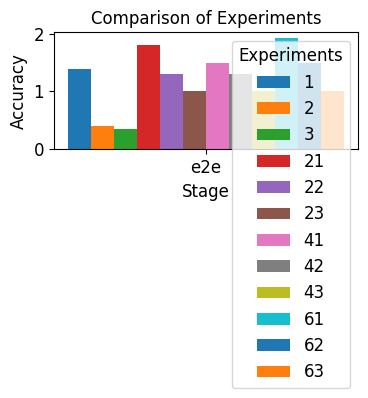

In [13]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
    # draw_temporal(accuracy_changes[series])
ylabel = "Accuracy"

accuracy_changes_total = {key: {'e2e': value['e2e']} for key, value in accuracy_changes.items()}

# make it average
for exp, value in accuracy_changes_total.items():
    value['e2e'] = (np.array(value['e2e']) / len(value['e2e'])).tolist()

draw_cumulative(
    accuracy_changes_total,
    multiple_experiments=True,
    ylabel=ylabel,
    series_names=series_names,
)